In [1]:
import sys
import os

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sys.path.insert(0, os.path.abspath("../cli"))
from simulation.sonar import Sonar
from simulation.utils import FlatBottom, CircleBottom, run_beam, positions_line, positions_half_circle
from simulation.plotting import plot_velocity, plot_attenuation

from examples.seismic import WaveletSource, Receiver
from devito import configuration

configuration['log-level'] = 'ERROR'
plt.rcParams['figure.figsize'] = (5, 5)

In [2]:
def plot_snapshot_and_signal(
    snap: npt.NDArray,
    recording: npt.NDArray,
    model,
    outfile,
):
    fig, ax = plt.subplots(
        2, 1, figsize=(10, 15), gridspec_kw={"width_ratios": [1], "height_ratios": [2, 1]}
    )
    snap_step = int(recording.shape[0] / snap.shape[0])
    data = model.vp.data
    ax[0].imshow(
        np.transpose(data),
        cmap="viridis",
        vmin=np.min(data),
        vmax=np.max(data),
    )
    ampl_limit = max(abs(np.min(snap)), abs(np.max(snap))) / 4
    matrice = ax[0].imshow(
        snap[0, :, :].T, vmin=-ampl_limit, vmax=ampl_limit, cmap="seismic", alpha=0.8
    )

    (aline,) = ax[1].plot(recording[:1])
    ax[1].set_ylim(1.1 * np.min(recording), 1.1 * np.max(recording))
    ax[1].set_xlim(0, len(recording))

    def update(i):
        matrice.set_array(snap[i, :, :].T)
        aline.set_data(np.arange(i * snap_step), recording[:i * snap_step])
        return (matrice,aline)


    ani = animation.FuncAnimation(
        fig, update, frames=snap.shape[0], interval=300, blit=True
    )
    ani.save(outfile)
    plt.close(ani._fig)
    

In [3]:
class GaborSource(WaveletSource):
    """
    A source object that encapsulates everything necessary for injecting a
    Gabor source into the computational domain.

    Returns:
        The source term that will be injected into the computational domain.
    """

    def __init_finalize__(self, *args, **kwargs):
        super(GaborSource, self).__init_finalize__(*args, **kwargs)

    @property
    def wavelet(self):
        assert self.f0 is not None
        agauss = 0.5 * self.f0
        tcut = self.t0 or 1.5 / agauss
        s = (self.time_values - 20 * tcut) * agauss
        a = self.a or 1
        return a * np.exp(-0.5 * s**2) * np.cos(2 * np.pi * s)

    @property
    def signal_packet(self):
        assert self.f0 is not None
        return self.wavelet[: np.searchsorted(self.time_values, 4 * 2 / self.f0)]

In [4]:
v_env = 1.5
ns = 128
domain_size = (10, 10)
source_distance = 0.002
cy = cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50
sonar = Sonar(domain_size, f0, v_env, FlatBottom())

In [5]:
src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src = GaborSource(
    name="src",
    grid=sonar.model.grid,
    npoint=ns,
    f0=f0,
    time_range=sonar.time_range,
    coordinates=src_coord,
)

rec = Receiver(
    name="rec",
    grid=sonar.model.grid,
    time_range=sonar.time_range,
    npoint=180,
    coordinates=positions_half_circle(5, 5, cy),
)

sonar.set_source(src, rec)
sonar.finalize(snapshot_delay=.1)

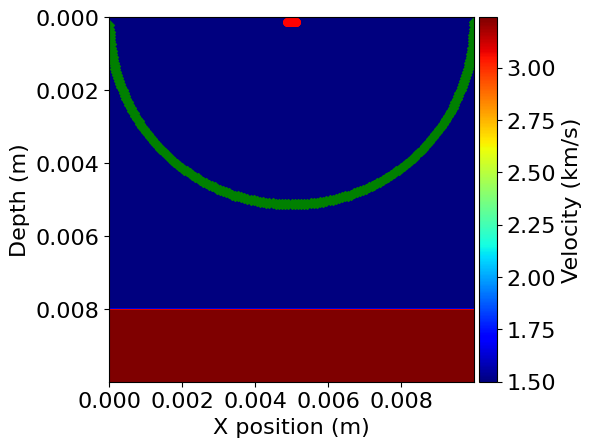

In [6]:
plot_velocity(sonar.model, source=src.coordinates.data, receiver=rec.coordinates.data)

In [7]:
recording = run_beam(
    src=src,
    rec=rec,
    op=sonar.op,
    u=sonar.u,
    source_distance=source_distance,
    time_range=sonar.time_range,
    dt=sonar.model.critical_dt,
    alpha=45,
    v_env=v_env,
)

In [9]:
plot_snapshot_and_signal(sonar.usave.data, recording[:, 65], sonar.model, "output/gabor_45.mp4")